## Visualize contracts stats

This notebook collects the data from `data` directory and plots graphs.

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import networkx as nx

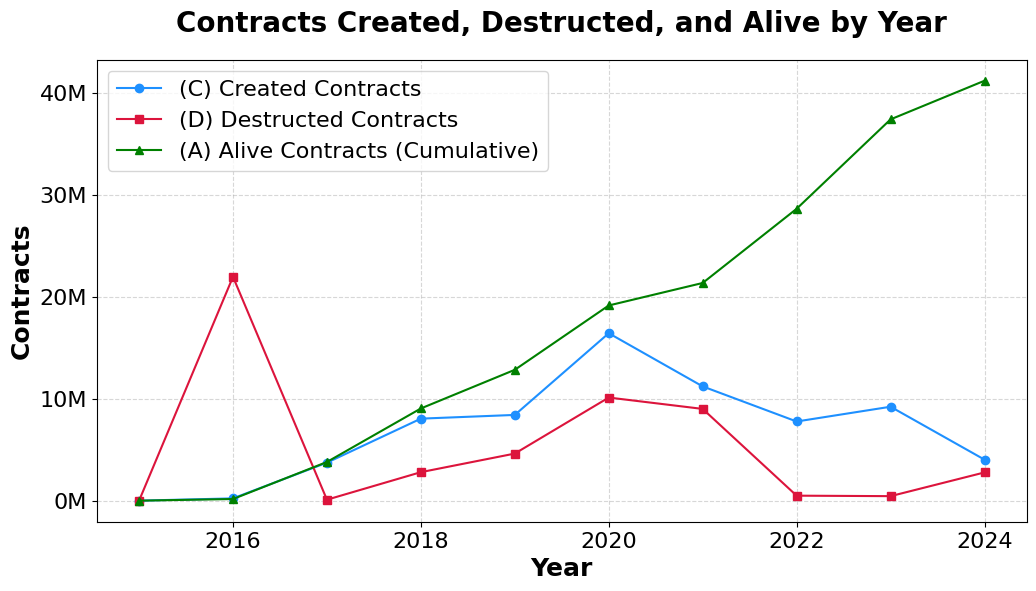

In [66]:
# Load data
create_df = pd.read_csv("../data/raw/create_by_year.csv")
destruct_df = pd.read_csv("../data/raw/destruct_by_year.csv")
alive_df = pd.read_csv("../data/raw/alive_contracts_year.csv")

# Update plot parameters for better readability
plt.rcParams.update({
    'font.size': 16,  # General font size
    'axes.labelsize': 18,  # Bigger axis labels
    'axes.labelweight': 'bold',
    'axes.titlesize': 20,  # Bigger title
    'xtick.labelsize': 16,  # Bigger tick labels
    'ytick.labelsize': 16,
    'legend.fontsize': 16  # Bigger legend
})

# Create the plot
plt.figure(figsize=(12, 6))  # Ensure same height


# Plot creation
plt.plot(create_df["year"], create_df["create_trace_count"], marker='o', linestyle='-', color='dodgerblue', label="(C) Created Contracts")

# Plot destruction
plt.plot(destruct_df["year"], destruct_df["destruct_trace_count"], marker='s', linestyle='-', color='crimson', label="(D) Destructed Contracts")

# Plot alive contracts
plt.plot(alive_df["year"], alive_df["n_alive_contracts"], marker='^', linestyle='-', color='green', label="(A) Alive Contracts (Cumulative)")

# Labels and title
plt.xlabel("Year", fontsize=18, fontweight='bold')
plt.ylabel("Contracts", fontsize=18, fontweight='bold')
plt.title("Contracts Created, Destructed, and Alive by Year", fontsize=20, pad=20, fontweight='bold')

# Format y-axis labels as 10M, 20M, etc.
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M'))  # Convert to millions
ax.yaxis.set_major_locator(ticker.MultipleLocator(10_000_000))  # Set ticks at 10M intervals

# Add legend and grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
# Save the plot
plt.savefig("../data/figures/created_destructed_alive.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

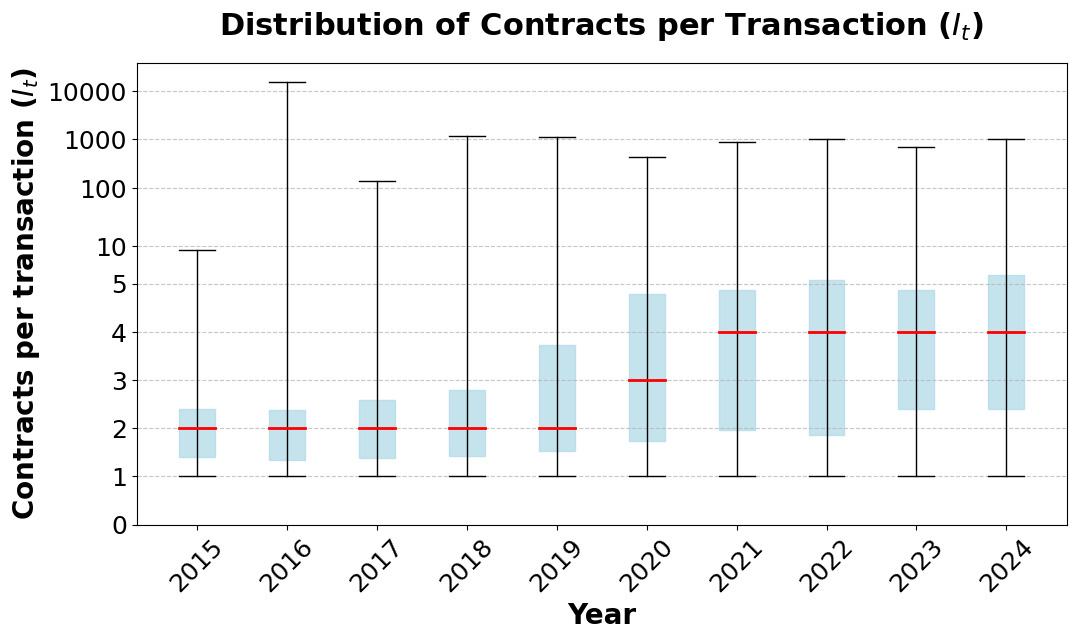

In [67]:

# Define the threshold for the hybrid scale
threshold = 5

# Function to transform the data
def hybrid_scale(y):
    """
    Apply a hybrid scale: linear below the threshold, logarithmic above.
    """
    # Ensure y is a numpy array
    y = np.asarray(y)
    # Apply linear scale for y <= threshold
    linear_part = np.where(y <= threshold, y, 0)
    # Apply logarithmic scale for y > threshold
    log_part = np.where(y > threshold, threshold + np.log10(np.maximum(y - threshold + 1, 1)), 0)
    # Combine the two parts
    return linear_part + log_part

# Function to reverse the transformation (for axis labels)
def hybrid_scale_inverse(y_transformed):
    """
    Reverse the hybrid scale transformation.
    """
    # Ensure y_transformed is a numpy array
    y_transformed = np.asarray(y_transformed)
    # Reverse linear scale for y_transformed <= threshold
    linear_part = np.where(y_transformed <= threshold, y_transformed, 0)
    # Reverse logarithmic scale for y_transformed > threshold
    log_part = np.where(y_transformed > threshold, 10**(y_transformed - threshold) + threshold - 1, 0)
    # Combine the two parts
    return linear_part + log_part

# Load and prepare data
years = range(2015, 2024 + 1)
dfs = []
for year in years:
    dfi = pd.read_csv(f"../data/raw/contracts_per_tx_{year}.csv")
    dfi["year"] = year
    dfs.append(dfi)

df = pd.concat(dfs)


# Function to calculate weighted percentiles
def weighted_percentile(data, weights, percentiles):
    """
    Calculate weighted percentiles.
    :param data: Array of values.
    :param weights: Array of weights (frequencies).
    :param percentiles: List of percentiles (e.g., [25, 50, 75]).
    :return: Array of percentile values.
    """
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    sorted_weights = weights[sorted_indices]
    cum_weights = np.cumsum(sorted_weights)
    total_weight = cum_weights[-1]
    percentile_positions = total_weight * np.array(percentiles) / 100
    percentiles_values = np.interp(percentile_positions, cum_weights, sorted_data)
    return percentiles_values

# Calculate boxplot statistics for each year
boxplot_stats = []
for year in years:
    df_year = df[df['year'] == year]
    addresses_called = df_year['addresses_called'].values
    frequencies = df_year['frequency'].values
    
    # Calculate weighted percentiles
    min_val = np.min(addresses_called)
    max_val = np.max(addresses_called)
    q1, median, q3 = weighted_percentile(addresses_called, frequencies, [25, 50, 75])
    
    # Store statistics
    boxplot_stats.append({
        'year': year,
        'min': min_val,
        'q1': q1,
        'median': int(np.round(median)),
        'q3': q3,
        'max': max_val
    })

# Convert to DataFrame
boxplot_df = pd.DataFrame(boxplot_stats)

# Create boxplot manually
plt.figure(figsize=(12, 6))  # Ensure same height
for i, row in boxplot_df.iterrows():
    year = row['year']
    # Transform the data using the hybrid scale
    min_transformed = hybrid_scale(row['min'])
    q1_transformed = hybrid_scale(row['q1'])
    median_transformed = hybrid_scale(row['median'])
    q3_transformed = hybrid_scale(row['q3'])
    max_transformed = hybrid_scale(row['max'])
    
    # Plot the transformed data
    plt.plot([year, year], [min_transformed, max_transformed], color='black', linewidth=1)  # Whiskers
    plt.plot([year - 0.2, year + 0.2], [min_transformed, min_transformed], color='black', linewidth=1)  # Lower whisker cap
    plt.plot([year - 0.2, year + 0.2], [max_transformed, max_transformed], color='black', linewidth=1)  # Upper whisker cap
    plt.fill_between([year - 0.2, year + 0.2], [q1_transformed, q1_transformed], [q3_transformed, q3_transformed], color='lightblue', alpha=0.7)  # Box
    plt.plot([year - 0.2, year + 0.2], [median_transformed, median_transformed], color='red', linewidth=2)  # Median line

# Customize y-axis labels
y_ticks = [0, 1, 2, 3, 4, 5, 10, 100, 1000, 10000]  # Original values
y_tick_labels = [str(x) for x in y_ticks]  # Labels for the original values
y_ticks_transformed = hybrid_scale(np.array(y_ticks))  # Transform the ticks

plt.yticks(y_ticks_transformed, labels=y_tick_labels, fontsize=18)  # Set custom ticks and labels (bold)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines

# Add titles and labels
plt.title("Distribution of Contracts per Transaction ($I_t$)", fontsize=22, pad=20, weight='bold')
plt.xlabel("Year", fontsize=20, weight='bold')
plt.ylabel("Contracts per transaction ($I_t$)", fontsize=20, weight='bold')
plt.xticks(years, rotation=45, fontsize=18)


# plt.tight_layout()

# Save and display the plot
plt.savefig("../data/figures/contracts_per_tx_year.pdf", format='pdf', bbox_inches='tight')
plt.show()

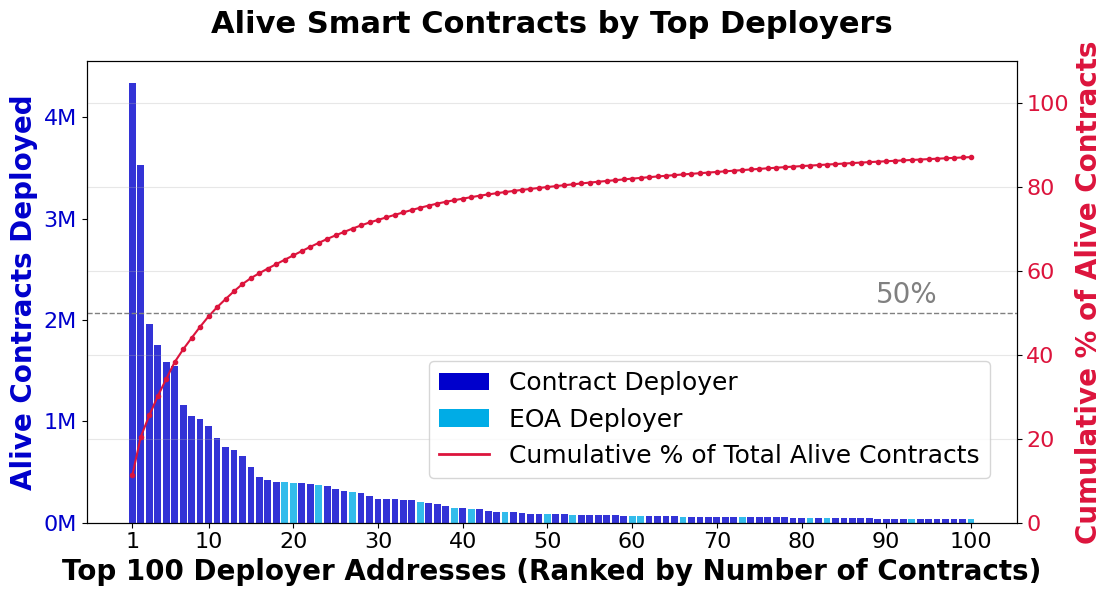

In [68]:

# Load the data
df = pd.read_csv("../data/raw/top_deployers_alive.csv")
eoa_df = pd.read_csv("../data/raw/top_eoa_deployers_filtered.csv")

# Sort the data
df = df.sort_values(by="deployed_alive_contracts", ascending=False)

# Compute cumulative sum and proportion
total_alive_contracts = df["deployed_alive_contracts"].sum()
df["cumulative_sum"] = df["deployed_alive_contracts"].cumsum()
df["cumulative_proportion"] = df["cumulative_sum"] / total_alive_contracts * 100

# Limit to top 51 addresses
df = df.iloc[:100].reset_index(drop=True)

# Set bar colors: light blue for EOAs, dark blue for others
eoa_addresses = set(eoa_df["address"])
df["color"] = df["address"].apply(lambda x: '#00ace6' if x in eoa_addresses else '#0000cc')  # Light blue vs default blue

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart
bars = ax1.bar(df.index, df["deployed_alive_contracts"], color=df["color"], alpha=0.8, label='Alive Contracts Deployed')
ax1.set_xlabel("Top 100 Deployer Addresses (Ranked by Number of Contracts)", fontsize=20)
# Define the custom x-ticks you want to show
xticks_to_show = [0] + [i for i in range(9, len(df), 10)]  # 0-indexed, so 0 (for 1), 9 (for 10), 19 (for 20), etc.
xtick_labels = [i + 1 for i in xticks_to_show]             # Convert to 1-based labels

# Apply the custom ticks
ax1.set_xticks(xticks_to_show)
ax1.set_xticklabels(xtick_labels)
ax1.set_ylabel("Alive Contracts Deployed", color='#0000cc', fontsize=20)
ax1.tick_params(axis='y', labelcolor='#0000cc')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Line chart
ax2 = ax1.twinx()
ax2.plot(df.index, df["cumulative_proportion"], marker='.', linestyle='-', color='crimson', label='Cumulative % of Total Alive Contracts')
ax2.set_ylabel("Cumulative % of Alive Contracts", color='crimson', fontsize=20)
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.set_ylim(0, 110)
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.text(len(df)*0.95, 51, '50%', color='gray', ha='right', va='bottom', fontsize=20)

# Title and grid
plt.title("Alive Smart Contracts by Top Deployers", fontsize=22, fontweight='bold', pad=20)
plt.grid(alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#0000cc', label='Contract Deployer'),
    Patch(facecolor='#00ace6', label='EOA Deployer'),
    plt.Line2D([0], [0], color='crimson', lw=2, label='Cumulative % of Total Alive Contracts')
]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.4, 0.4), fontsize=18)

plt.rcParams.update({
    'font.size': 20,  # General font size
    'axes.labelsize': 20,  # Bigger axis labels
    'axes.labelweight': 'bold',
    'axes.titlesize': 20,  # Bigger title
    'xtick.labelsize': 20,  # Bigger tick labels
    'ytick.labelsize': 20,
    'legend.fontsize': 20  # Bigger legend
})

# plt.tight_layout()
plt.savefig("../data/figures/top_100_deployers.pdf", format='pdf', bbox_inches='tight')
plt.show()


[]
Number of all nodes: 69
Number of nodes in each color group:
Color group 0: 21 nodes
Color group 1: 31 nodes
Color group 2: 17 nodes
Number of unverified nodes in each color group:
Color group 0: 3 unverified nodes
Color group 1: 0 unverified nodes
Color group 2: 0 unverified nodes


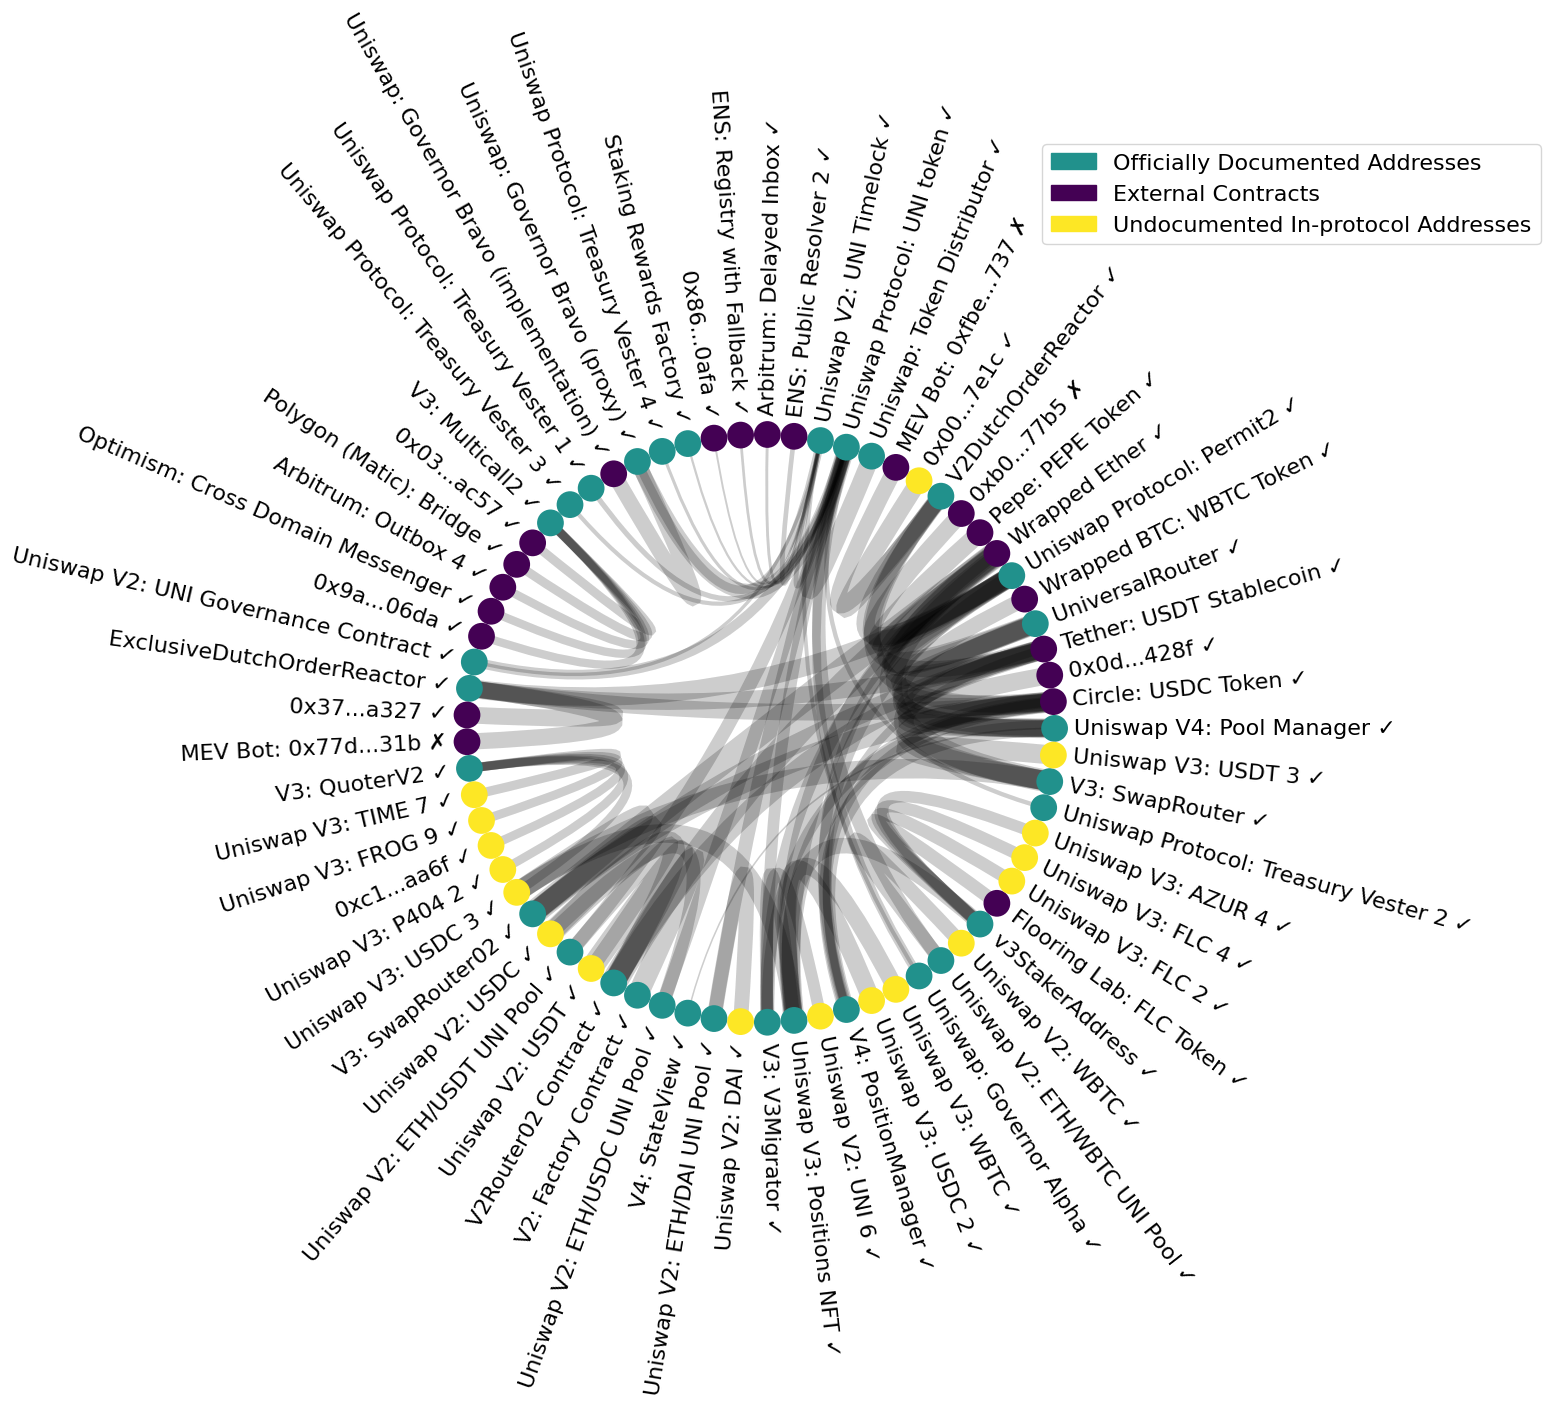

In [75]:
import networkx as nx
import nxviz as nv
from nxviz import annotate
import numpy as np
import requests
from bs4 import BeautifulSoup

official_labels_file_path = "../data/raw/uniswap_all.csv"
contracts_file_path = "../data/raw/uniswap_top_5_to_addr.csv"
creators_file_path = "../data/raw/uniswap_top_10_to_creators.csv"

plt.rcParams.update({
    'font.size': 16,  # General font size
    'axes.labelsize': 16,  # Bigger axis labels
    'axes.labelweight': 'bold',
    'axes.titlesize': 16,  # Bigger title
    'xtick.labelsize': 16,  # Bigger tick labels
    'ytick.labelsize': 16,
    'legend.fontsize': 16  # Bigger legend
})


def get_contract_verification_status(contract_address, api_key):
    """
    Query Etherscan API to check if the contract's source code is verified.
    Returns True if verified, False if not verified, and None if API request fails.
    """
    url = "https://api.etherscan.io/api"
    params = {
        "module": "contract",
        "action": "getabi",
        "address": contract_address,
        "apikey": api_key,
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if (
            data["status"] == "1"
            and data["result"] != "Contract source code not verified"
        ):
            return True
        else:
            print(f"Response for {contract_address}: {data}")
            return False
    else:
        return None

def get_etherscan_label(address):
    url = f"https://etherscan.io/address/{address}"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching {address}: {e}")
        return "Error"

    soup = BeautifulSoup(response.text, 'html.parser')
    label_tag = soup.find('span', {'class': 'hash-tag text-truncate lh-sm my-n1'})
    
    if label_tag:
        return label_tag.get_text(strip=True)
    else:
        return None

# def update_verification_status(G):
#     """
#     Update each node in the graph with its verification status.
#     Verified nodes get a tick ("✓") while non-verified ones get a cross ("✗").
#     """
#     for node in G.nodes():
#         is_verified = get_contract_verification_status(node, api_key)
#         print(f"Contract {node} is {'verified' if is_verified else 'not verified'}.")
#         G.nodes[node]["verified"] = "✓" if is_verified else "✗"
#     return G
def get_etherscan_verified(address):
    url = f"https://etherscan.io/address/{address}"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching {address}: {e}")
        return "Error"

    soup = BeautifulSoup(response.text, 'html.parser')
    label_tag = soup.find('span', {'class': 'badge bg-success bg-opacity-10 border border-success border-opacity-25 text-green-600 text-nowrap rounded-pill py-1.5 px-2'})
    
    if label_tag:
        return label_tag.get_text(strip=True) == "Source Code"
    else:
        return False

def load_data(contracts_file, labels_file, creators_file):
    """Load contracts and address labels data from CSV files."""
    data = pd.read_csv(contracts_file)
    address_labels = pd.read_csv(labels_file)
    creators = pd.read_csv(creators_file)
    created = creators["to_address"].unique()
    to_addresses = data["to_address"].unique()

    # get all addresses in labels
    addresses_w_label = address_labels["address"].unique()
    #get the addresses that are not in the labels
    addresses_wo_label = [address for address in to_addresses if address not in addresses_w_label]
    print(addresses_wo_label)
    for addr in addresses_wo_label:
        label = get_etherscan_label(addr)
        verified = get_etherscan_verified(addr)
        print(f"Address {addr} has label {label}")
        address_labels.loc[len(address_labels)] = [addr, False, label, verified]
    # update labels file
    address_labels.to_csv(labels_file, index=False)
    # Create a dictionary for quick label lookup (keys in lowercase)
    address_group_dict = {
        k.lower(): bool(v) for k, v in zip(address_labels["address"], address_labels["uniswap"])
    }
    address_label_dict = {
        k.lower(): v for k, v in zip(address_labels["address"], address_labels["label"]) if pd.notna(v)
    }
    verified_dict = {
        k.lower(): bool(v) for k, v in zip(address_labels["address"], address_labels["verified"]) if pd.notna(v)
    }
    return data, address_label_dict, address_group_dict, verified_dict, created


def build_graph(data):
    """Create a graph from the contract interactions data."""
    G = nx.Graph()
    for _, row in data.iterrows():
        G.add_edge(
            row["from_address"].lower(),
            row["to_address"].lower(),
            weight=row["call_count"],
        )
    return G


def remove_invalid_nodes(G):
    """Remove nodes with addresses starting with the invalid pattern."""
    invalid_nodes = [
        node
        for node in G.nodes()
        if str(node).startswith("0x000000000000000000000000000000000000000")
    ]
    G.remove_nodes_from(invalid_nodes)
    return G


def relabel_nodes_with_labels(G, address_label_dict, verified_dict):
    """
    Relabel nodes using the provided address labels dictionary.
    Then, shorten long hexadecimal addresses and append the verification tick.
    """
    for node in G.nodes():
        is_verified = verified_dict.get(node, False)
        G.nodes[node]["verified"] = "✓" if is_verified else "✗"
    # Replace addresses with official labels if available
    G = nx.relabel_nodes(G, address_label_dict)
    # For any node that is still an address, shorten it (e.g., 0x1234...abcd)
    G = nx.relabel_nodes(
        G, lambda x: x[:4] + "..." + x[-4:] if str(x).startswith("0x") else x
    )
    # Append verification status to each node label
    G = nx.relabel_nodes(G, lambda x: x + " " + str(G.nodes[x]["verified"]))
    return G


def apply_edge_transformations(G):
    """Apply logarithmic transformation to the edge weights."""
    for u, v, d in G.edges(data=True):
        d["log_weight"] = np.log1p(d["weight"])
    return G


def assign_color_groups(G, address_group_dict, created):
    """
    Assign a color group to each node based on whether it is an address.
    Nodes that start with '0x' are group 0; all others are group 1.
    """
    for node in G.nodes():
        if address_group_dict.get(str(node)) == True:
            G.nodes[node]["color_group"] = 1
        elif str(node) in created:
            G.nodes[node]["color_group"] = 2
        else:
            G.nodes[node]["color_group"] = 0
    return G


def generate_plot(G):
    """Generate a circos plot of the network using nxviz and save the output."""
    plt.figure(figsize=(15, 15))
    nv.circos(G, node_color_by="color_group", edge_lw_by="log_weight")
    annotate.circos_labels(G, layout="rotate")
    labels = ["Officially Documented Addresses",
               "External Contracts",
               "Undocumented In-protocol Addresses"
               ]
        
    legends = {"loc": "lower left", "borderaxespad": 0.5, "title_fontsize": 12, "labels": labels, "bbox_to_anchor": (0.9, 1.2)
    }
    annotate.node_colormapping(G, "color_group", legend_kwargs=legends)
    plt.tight_layout()
    # plt.savefig(output_file)
    plt.savefig("../data/figures/uniswap_network.pdf", format='pdf', bbox_inches='tight')
    plt.show()


def print_node_statistics(G):       
    """Print the number of nodes and their distribution by color group."""
    print(f"Number of all nodes: {len(G.nodes())}")
    color_group_counts = {0: 0, 1: 0, 2: 0}
    unverified_count = {0: 0, 1: 0, 2: 0}
    for node in G.nodes():
        color_group = G.nodes[node]["color_group"]
        color_group_counts[color_group] += 1
        if G.nodes[node]["verified"] == "✗":
            unverified_count[color_group] += 1
    print("Number of nodes in each color group:")
    for group, count in color_group_counts.items():
        print(f"Color group {group}: {count} nodes")
    print("Number of unverified nodes in each color group:")
    for group, count in unverified_count.items():
        print(f"Color group {group}: {count} unverified nodes")


# Load data and build initial graph
data, address_label_dict, address_group_dict, verified_dict, created = load_data(contracts_file_path, official_labels_file_path, creators_file_path)
G = build_graph(data)
G = remove_invalid_nodes(G)



# Apply transformations to edge weights and assign color groups to nodes
G = apply_edge_transformations(G)
G = assign_color_groups(G, address_group_dict, created)
# Relabel nodes with official labels and verification ticks
G = relabel_nodes_with_labels(G, address_label_dict, verified_dict)

# Print some statistics about the graph
print_node_statistics(G)

# Generate and save the network plot
generate_plot(G)

# save the graph as pdf
